In [1]:
!pip install -q transformers
!apt-get -qq install -y ffmpeg


In [2]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Fix random seed

In [3]:
# fix random seed
import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Tokenization and creation of CLS vector of the text

In [4]:
! pip install requests


# Download data and extract it

In [5]:
import os
import requests
import tarfile

def download_and_extract(url, target_folder):
    # Create the target folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)

    # Get the filename from the URL
    filename = url.split("/")[-1]

    # Download the file
    file_path = os.path.join(target_folder, filename)
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(target_folder)

    os.remove(file_path)

# URL of the tar.gz file
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

target_folder = "data_folder"

download_and_extract(url, target_folder)


In [6]:
import os
import pandas as pd

def load_imdb_dataset():
    data = []
    labels = []

    folder_path = os.path.join('data_folder', 'aclImdb', 'train')

    for category in ['pos', 'neg']:
        category_folder = os.path.join(folder_path, category)
        files = os.listdir(category_folder)

        for file in files:
            with open(os.path.join(category_folder, file), 'r', encoding='utf-8') as f:
                text = f.read()
            data.append(text)
            labels.append(1 if category == 'pos' else 0)

    df = pd.DataFrame({'review_text': data, 'sentiment_label': labels})
    return df

# Load the dataset
df = load_imdb_dataset()

# Display some samples
print(df.head())


                                         review_text  sentiment_label
0  Unique movie about confused woman (Lindsay Cro...                1
1  As a Pagan, I must say this movie has little i...                1
2  A fabulous film. With everything you could wan...                1
3  I'm one of those people who usually watch prog...                1
4  I am and was very entertained by the movie. It...                1


In [7]:
import pandas as pd
import random

# filter
filtered_positive_samples = df[(df['sentiment_label'] == 1) & (df['review_text'].str.len().between(5, 200))]
filtered_negative_samples = df[(df['sentiment_label'] == 0) & (df['review_text'].str.len().between(5, 200))]

selected_samples = pd.concat([filtered_positive_samples, filtered_negative_samples])

selected_samples = selected_samples.reset_index(drop=True)

texts = selected_samples['review_text'].tolist()
labels = selected_samples['sentiment_label'].tolist()

print("Selected Texts:")
print(texts[:3])
print("Selected Labels:")
print(labels[:3])



Selected Texts:
['This movie is very good. The screenplay is enchanting. But Meryl Streep is most impressive. Her performance is excellent. She brings me to go into the heart of her role.', 'Although not one of Vonnegut\'s better known works, it is a definite "must-see". Interestingly thought out, I especially like how the director filmed the couple in love.', "The only thing serious about this movie is the humor. Well worth the rental price. I'll bet you watch it twice. It's obvious that Sutherland enjoyed his role."]
Selected Labels:
[1, 1, 1]


In [8]:
import torch

def get_cls_vectors(texts, labels, tokenizer, model):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states
    cls_vectors = [layer[:, 0, :].numpy() for layer in hidden_states]

    return cls_vectors

cls_vectors = get_cls_vectors(texts, labels, tokenizer, model)


# Dimensionality reduction and 2d plot through layers (red = 0 = negative and blue = 1 = positive labels)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


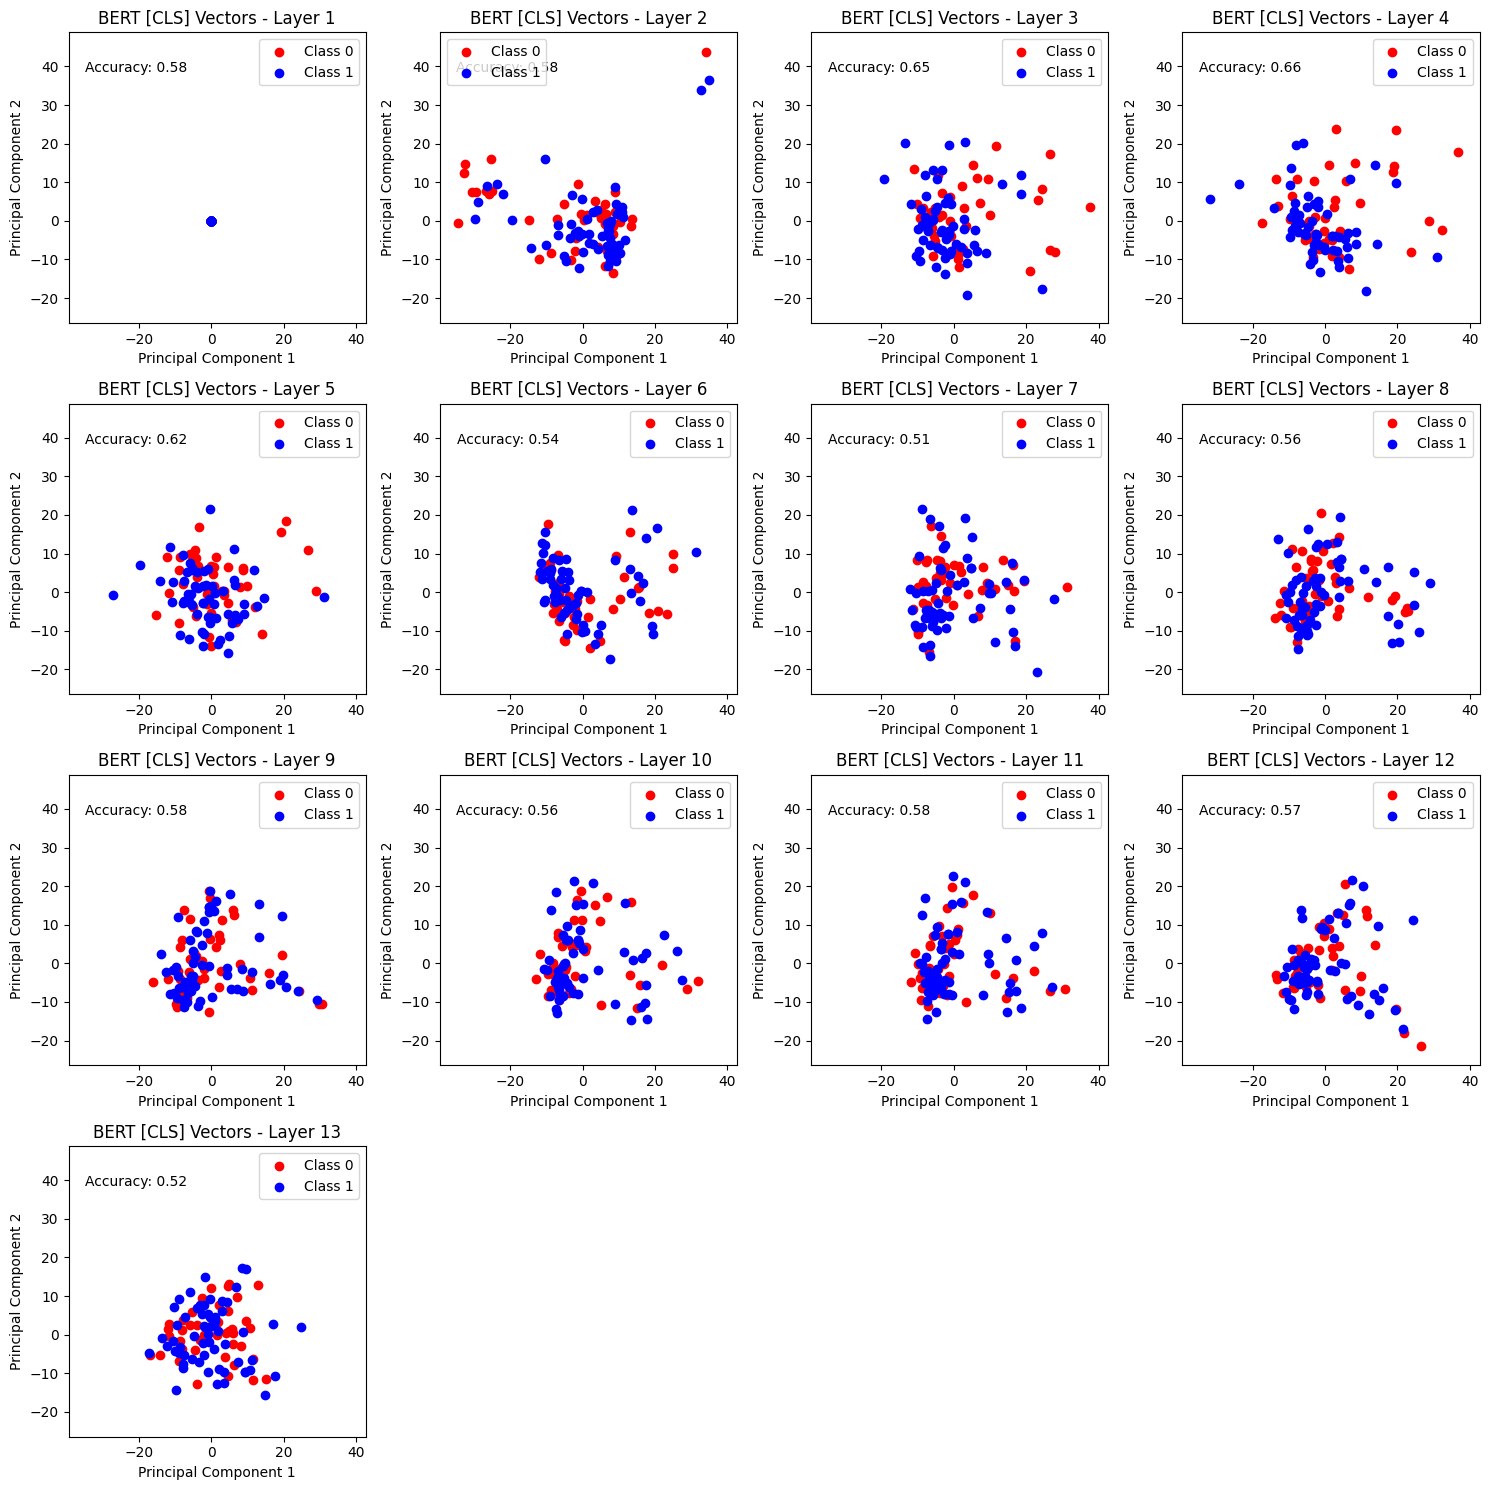

+----------+------------+
| Layer    |   Accuracy |
+==========+============+
| Layer 1  |       0.58 |
+----------+------------+
| Layer 2  |       0.58 |
+----------+------------+
| Layer 3  |       0.65 |
+----------+------------+
| Layer 4  |       0.66 |
+----------+------------+
| Layer 5  |       0.62 |
+----------+------------+
| Layer 6  |       0.54 |
+----------+------------+
| Layer 7  |       0.51 |
+----------+------------+
| Layer 8  |       0.56 |
+----------+------------+
| Layer 9  |       0.58 |
+----------+------------+
| Layer 10 |       0.56 |
+----------+------------+
| Layer 11 |       0.58 |
+----------+------------+
| Layer 12 |       0.57 |
+----------+------------+
| Layer 13 |       0.52 |
+----------+------------+


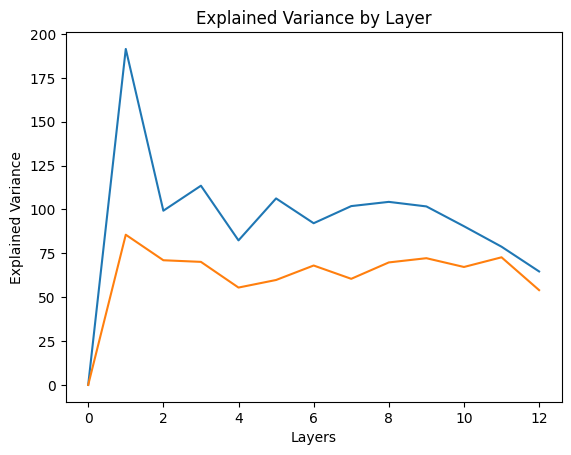

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_pca_2(cls_vectors, num_components=2):
   # Standardize the data
    scaler = StandardScaler()

    scaled_vectors = [scaler.fit_transform(vector) for vector in cls_vectors]
    pca = PCA(n_components=num_components)
    # get the reduced vectors and the pca explaned ratio for each
    reduced_vectors = []
    explained_ratio = []
    for vector in scaled_vectors:
        reduced_vector = pca.fit_transform(vector)

        reduced_vectors.append(reduced_vector)
        explained_ratio.append(pca.explained_variance_)
    return reduced_vectors, explained_ratio

def visualize_in_grid(reduced_vectors, labels):
    # Set common x-axis and y-axis limits for all plots
    min_x = min(v[:, 0].min() for v in reduced_vectors)
    max_x = max(v[:, 0].max() for v in reduced_vectors)
    min_y = min(v[:, 1].min() for v in reduced_vectors)
    max_y = max(v[:, 1].max() for v in reduced_vectors)
    xlim = (min_x - 5, max_x + 5)
    ylim = (min_y - 5, max_y + 5)

    # Create a color map for the classes
    colors = {0: 'red', 1: 'blue'}

    # Visualize the vectors using separate plots for each layer 4 x N
    num_layers = len(reduced_vectors)
    num_rows = 4
    num_cols = (num_layers - 1) // num_rows + 1

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    accuracies_avg = []
    for i, layer_vectors in enumerate(reduced_vectors):
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axes[row_idx, col_idx]

        layer_name = f"Layer {i + 1}"
        for label, color in colors.items():
            indices = [j for j in range(len(labels)) if labels[j] == label]
            ax.scatter(layer_vectors[indices, 0], layer_vectors[indices, 1], label=f"Class {label}", color=color)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_title(f"BERT [CLS] Vectors - Layer {i + 1}")

        # Evaluate separability with logistic regression and cross-validation
        logistic_reg = LogisticRegression(random_state=42)
        accuracy_scores = cross_val_score(logistic_reg, reduced_vectors[i], labels, cv=5)
        mean_accuracy = accuracy_scores.mean()
        accuracies_avg.append(mean_accuracy)
        ax.text(0.4, 0.9, f"Accuracy: {mean_accuracy:.2f}", ha='right', va='top', transform=ax.transAxes)

        ax.legend()

    for i in range(len(reduced_vectors), num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

    plt.tight_layout()
    plt.show()

    # Print the accuracy table
    table_data = [[f"Layer {i + 1}", f"{accuracy:.2f}"] for i, accuracy in enumerate(accuracies_avg)]
    table_headers = ["Layer", "Accuracy"]
    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

# Perform PCA
reduced_vectors, explain_vars = perform_pca_2(cls_vectors)

# Visualize in grid
visualize_in_grid(reduced_vectors, labels)

def plot_explained_variance(explain_vars):
    plt.plot(explain_vars)
    plt.title('Explained Variance by Layer')
    plt.xlabel('Layers')
    plt.ylabel('Explained Variance')
    plt.show()


plot_explained_variance(explain_vars)



# Test in Toy data


# Dataset: Load, preprocess, select sentences for the toy


In [10]:
!pip install datasets


In [11]:
# Install the datasets library if not already installed

# Import the datasets library
from datasets import load_dataset
import pandas as pd
import random

# Load a subset of the Amazon Polarity dataset
dataset = load_dataset('amazon_polarity', split='train[:2000]')

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Select relevant columns and rename them
df = df[['content', 'label']]
df.columns = ['review_body', 'label']

# Sample a small subset of the data to create a toy dataset
sampled_data = df.sample(n=100, random_state=42)

# Extract texts and labels
texts_toy = sampled_data['review_body'].tolist()
labels_toy = sampled_data['label'].tolist()

# Display the toy dataset
for text, label in zip(texts_toy, labels_toy):
    print(f"Text: {text}\nLabel: {label}\n")
    break


Text: I loved this book, but when I got "Making Memory Books and Journals by Hand" I was surprised to find "Making Journals by Hand" is actually included in that text in full: word for word, page for page, project for project .Instead of buying "Making Journals by Hand" and "Making Memory Boxes", save some money and buy one book: "Making Memory Books and Journals by Hand". This book combines all of the projects above and then some.All of these books have great projects and instructions.
Label: 1



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


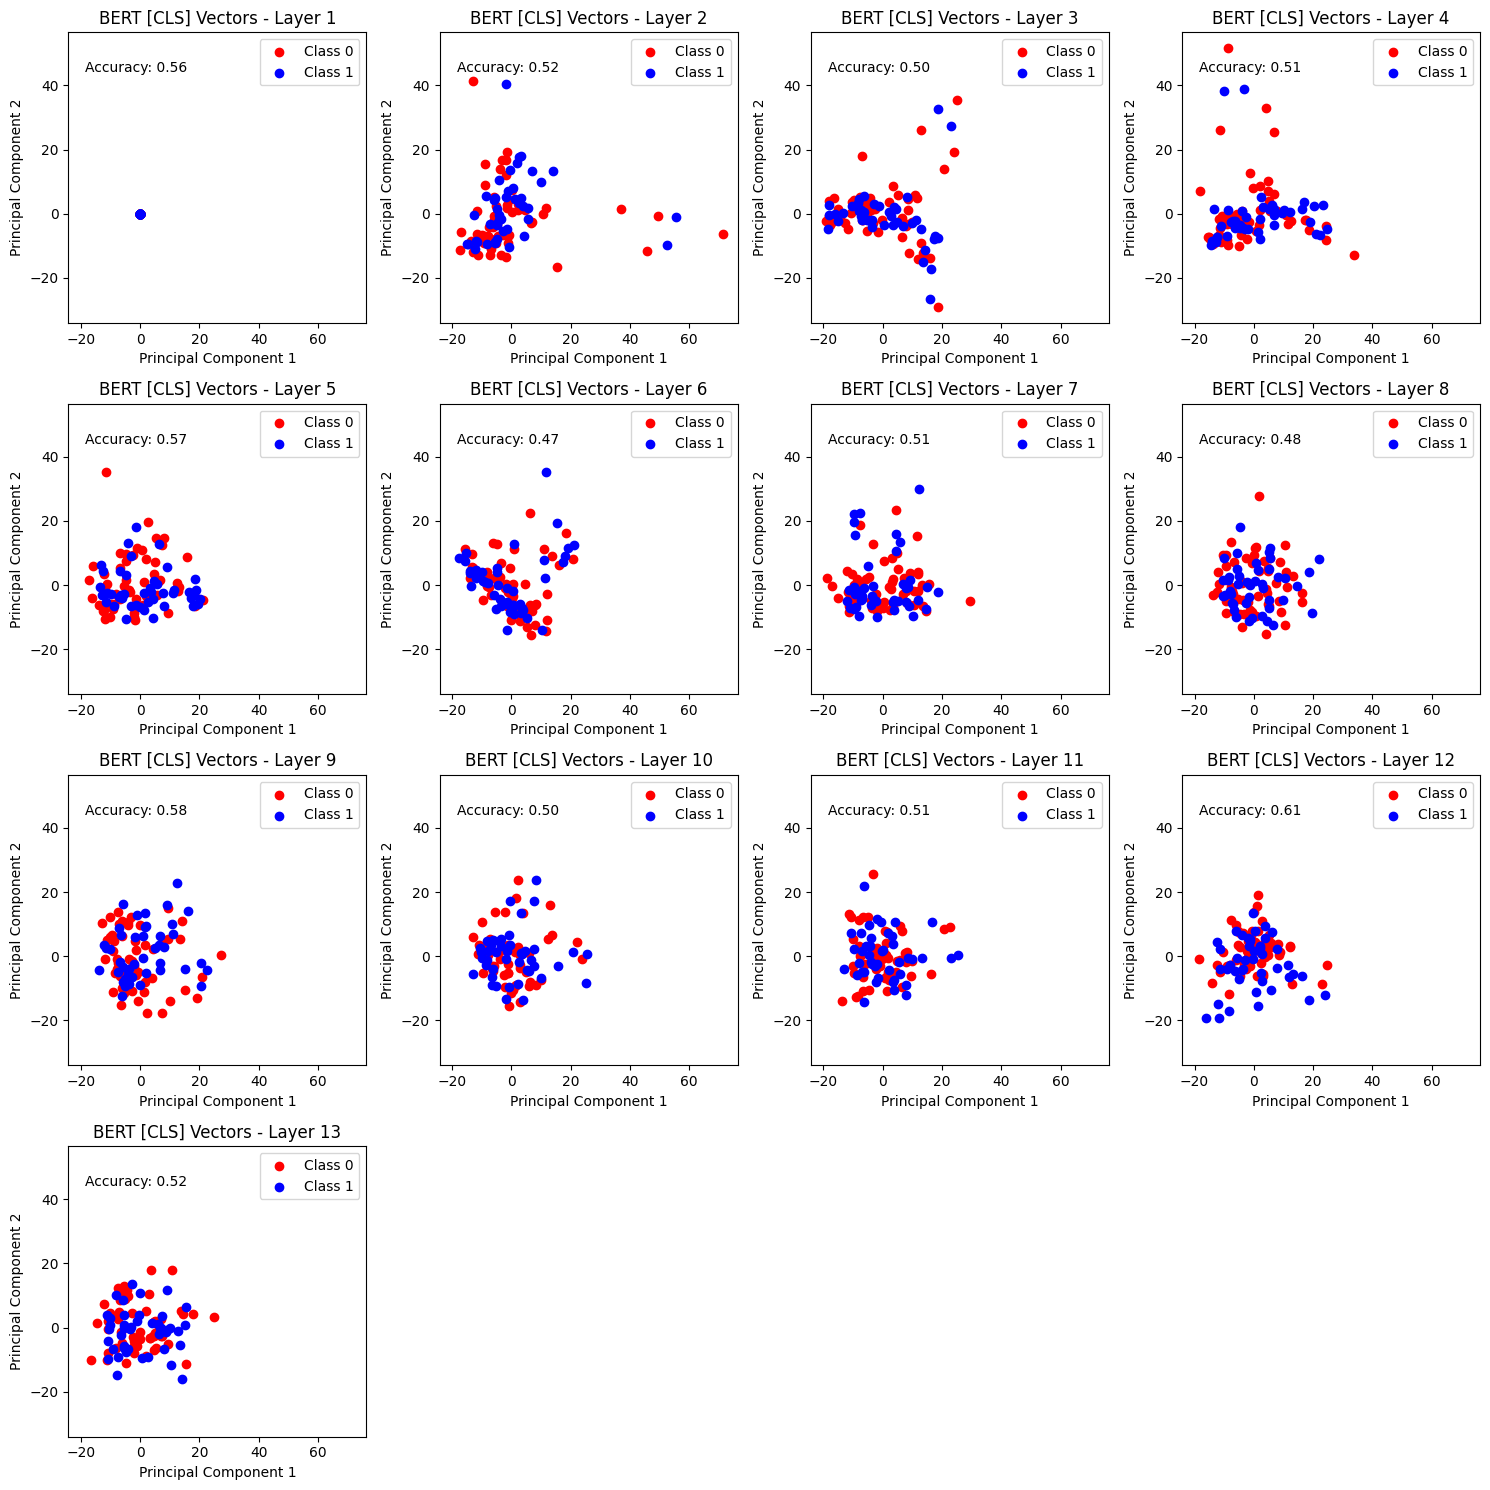

+----------+------------+
| Layer    |   Accuracy |
+==========+============+
| Layer 1  |       0.56 |
+----------+------------+
| Layer 2  |       0.52 |
+----------+------------+
| Layer 3  |       0.5  |
+----------+------------+
| Layer 4  |       0.51 |
+----------+------------+
| Layer 5  |       0.57 |
+----------+------------+
| Layer 6  |       0.47 |
+----------+------------+
| Layer 7  |       0.51 |
+----------+------------+
| Layer 8  |       0.48 |
+----------+------------+
| Layer 9  |       0.58 |
+----------+------------+
| Layer 10 |       0.5  |
+----------+------------+
| Layer 11 |       0.51 |
+----------+------------+
| Layer 12 |       0.61 |
+----------+------------+
| Layer 13 |       0.52 |
+----------+------------+


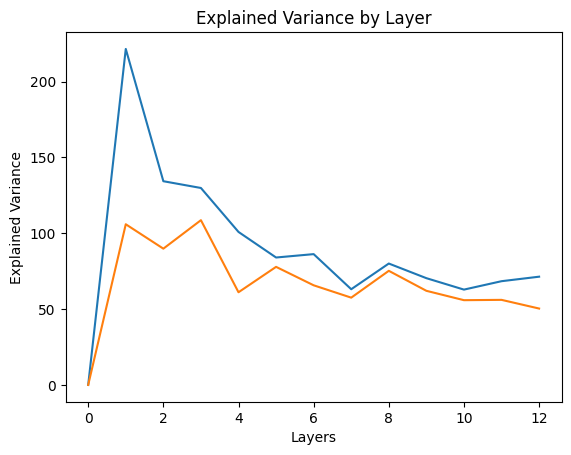

In [12]:
cls_vectors_toy = get_cls_vectors(texts_toy, labels_toy, tokenizer, model)

reduced_vectors_toy, exp_var_toy = perform_pca_2(cls_vectors_toy)

visualize_in_grid(reduced_vectors_toy, labels_toy)

plot_explained_variance(exp_var_toy)

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

def perform_svd(cls_vectors, num_components=2):
    # Standardize the data
    scaler = StandardScaler()

    scaled_vectors = [scaler.fit_transform(vector) for vector in cls_vectors]
    svd = TruncatedSVD(n_components=num_components)
    # get the reduced vectors and the explained variance ratio for each
    reduced_vectors = []
    explained_ratio = []
    for vector in scaled_vectors:
        reduced_vector = svd.fit_transform(vector)

        reduced_vectors.append(reduced_vector)
        explained_ratio.append(svd.explained_variance_ratio_)
    return reduced_vectors, explained_ratio


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_truncated_svd.py:268: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


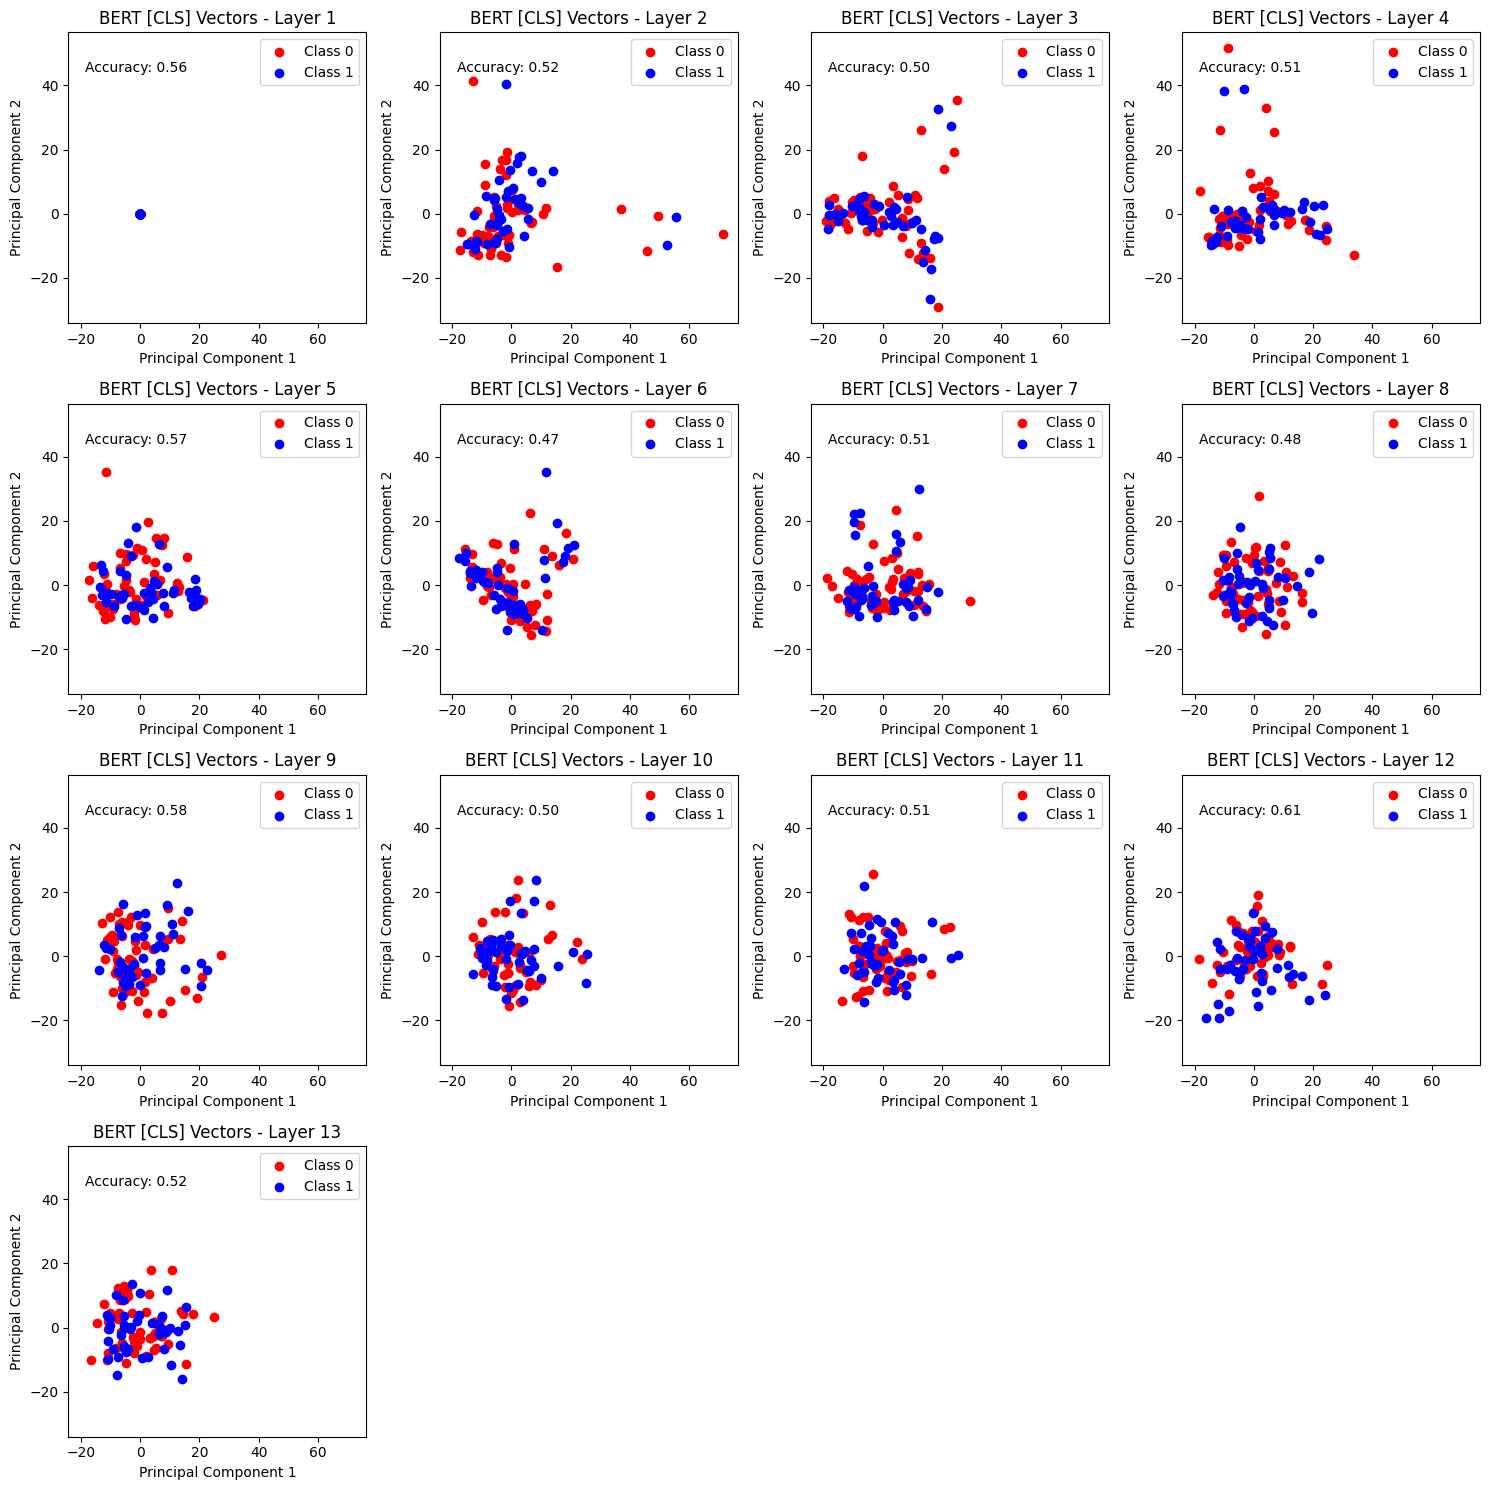

+----------+------------+
| Layer    |   Accuracy |
+==========+============+
| Layer 1  |       0.56 |
+----------+------------+
| Layer 2  |       0.52 |
+----------+------------+
| Layer 3  |       0.5  |
+----------+------------+
| Layer 4  |       0.51 |
+----------+------------+
| Layer 5  |       0.57 |
+----------+------------+
| Layer 6  |       0.47 |
+----------+------------+
| Layer 7  |       0.51 |
+----------+------------+
| Layer 8  |       0.48 |
+----------+------------+
| Layer 9  |       0.58 |
+----------+------------+
| Layer 10 |       0.5  |
+----------+------------+
| Layer 11 |       0.51 |
+----------+------------+
| Layer 12 |       0.61 |
+----------+------------+
| Layer 13 |       0.52 |
+----------+------------+


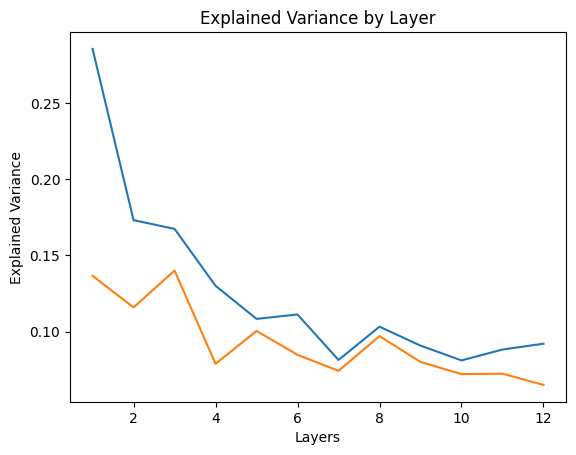

In [14]:
cls_vectors_toy = get_cls_vectors(texts_toy, labels_toy, tokenizer, model)

reduced_vectors_toy, exp_var_toy = perform_svd(cls_vectors_toy)

visualize_in_grid(reduced_vectors_toy, labels_toy)

plot_explained_variance(exp_var_toy)